
# Análise Completa da Qualidade do Café (Arabica)

Notebook para explorar, limpar e modelar o dataset **arabica_data_cleaned.csv**.

Inclui:
- Exploração descritiva
- Tratamento de dados faltantes
- Visualizações
- Engenharia de atributos
- Modelos preditivos (regressão e classificação)


In [1]:

# ## 1. Setup
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (mean_absolute_error, r2_score, mean_squared_error,
                             accuracy_score, f1_score, classification_report,
                             confusion_matrix, roc_auc_score, RocCurveDisplay)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.inspection import permutation_importance

pd.set_option("display.max_columns", 100)


In [2]:

# ## 2. Carregamento do Dataset
df = pd.read_csv("arabica_data_cleaned.csv", encoding="utf-8")
print("Formato:", df.shape)
display(df.head(10))
display(df.sample(min(10, len(df))))

print("\nTipos de dados:")
print(df.dtypes)

print("\nPercentual de faltantes (Top 20):")
missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(20).to_frame("pct_missing"))


Formato: (1311, 44)


,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,Producer,Number.of.Bags,Bag.Weight,In.Country.Partner,Harvest.Year,Grading.Date,Owner.1,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,NaN,Washed / Wet,8.67,8.83,8.67,8.75,8.50,8.42,10.00,10.0,10.00,8.75,90.58,0.12,0,0.0,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,2,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,Other,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.00,10.0,10.00,8.58,89.92,0.12,0,0.0,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,3,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,NaN,NaN,5,1,Specialty Coffee Association,NaN,"May 31st, 2010",Grounds for Health Admin,Bourbon,NaN,8.42,8.50,8.42,8.42,8.33,8.42,10.00,10.0,10.00,9.25,89.75,0.00,0,0.0,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0
3,4,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,oromia,Yidnekachew Dabessa Coffee Plantation,320,60 kg,METAD Agricultural Development plc,2014,"March 26th, 2015",Yidnekachew Dabessa,NaN,Natural / Dry,8.17,8.58,8.42,8.42,8.50,8.25,10.00,10.0,10.00,8.67,89.00,0.11,0,0.0,Green,2,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0
4,5,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,Other,Washed / Wet,8.25,8.50,8.25,8.50,8.42,8.33,10.00,10.0,10.00,8.58,88.83,0.12,0,0.0,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
5,6,Arabica,ji-ae ahn,Brazil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,30 kg,Specialty Coffee Institute of Asia,2013,"September 3rd, 2013",Ji-Ae Ahn,NaN,Natural / Dry,8.58,8.42,8.42,8.50,8.25,8.33,10.00,10.0,10.00,8.33,88.83,0.11,0,0.0,Bluish-Green,1,"September 3rd, 2014",Specialty Coffee Institute of Asia,726e4891cf2c9a4848768bd34b668124d12c4224,b70da261fcc84831e3e9620c30a8701540abc200,m,NaN,NaN,NaN
6,7,Arabica,hugo valdivia,Peru,NaN,NaN,hvc,NaN,richmond investment-coffee department,NaN,NaN,HVC,100,69 kg,Specialty Coffee Institute of Asia,2012,"September 17th, 2012",Hugo Valdivia,Other,Washed / Wet,8.42,8.50,8.33,8.50,8.25,8.25,10.00,10.0,10.00,8.50,88.75,0.11,0,0.0,Bluish-Green,0,"September 17th, 2013",Specialty Coffee Institute of Asia,726e4891cf2c9a4848768bd34b668124d12c4224,b70da261fcc84831e3e9620c30a8701540abc200,m,NaN,NaN,NaN
7,8,Arabica,ethiopia commodity exchange,Ethiopia,aolme,NaN,c.p.w.e,010/0338,NaN,1570-1700,oromia,Bazen Agricultural & Industrial Dev't Plc,300,60 kg,Ethiopia Commodity Exchange,March 2010,"September 2nd, 2010",Ethiopia Commodity Exchange,NaN,NaN,8

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,Producer,Number.of.Bags,Bag.Weight,In.Country.Partner,Harvest.Year,Grading.Date,Owner.1,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
424,425,Arabica,"lin, che-hao krude 林哲豪",Taiwan,sunshine valley estate 向陽高山咖啡,NaN,sunshine valley estate 向陽高山咖啡,Taiwan,taiwan coffee laboratory,1000 m,natou county,LIN YEN CHIEN 林言謙,10,15 kg,Specialty Coffee Association,2015,"June 18th, 2015","Lin, Che-Hao Krude 林哲豪",Bourbon,Washed / Wet,7.67,7.50,7.50,7.50,7.67,7.83,10.00,10.0,10.0,7.58,83.25,0.10,0,0.0,Blue-Green,0,"June 17th, 2016",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1000.0,1000.0,1000.0
157,158,Arabica,nucoffee,Brazil,fazenda vista alegre,NaN,NaN,002/1251/0076,nucoffee,1100m,mountains of minas gerais,Geraldo Paixão,35,60 kg,NUCOFFEE,2011,"December 3rd, 2011",NUCOFFEE,Catuai,Semi-washed / Semi-pulped,8.50,8.00,7.50,7.75,7.50,7.83,10.00,10.0,10.0,7.50,84.58,0.11,0,0.0,Blue-Green,1,"December 2nd, 2012",NUCOFFEE,567f200bcc17a90070cb952647bf88141ad9c80c,aa2ff513ffb9c844462a1fb07c599bce7f3bb53d,m,1100.0,1100.0,1100.0
916,917,Arabica,santa laura exportadora de cafe s.l.e.c. s.a.,Costa Rica,several,NaN,several,5-545-0006,santa laura exportadora de cafe s.l.e.c. s.a.,1200 msm,occidental,Beneficio la Eva S.A.,250,1 kg,Specialty Coffee Association of Costa Rica,2014,"January 7th, 2015",Santa Laura Exportadora de Cafe S.L.E.C. S.A.,Caturra,Washed / Wet,7.83,7.33,7.08,7.08,7.33,7.50,10.00,10.0,10.0,7.33,81.50,0.12,1,0.0,Green,2,"January 7th, 2016",Specialty Coffee Association of Costa Rica,8e0b118f3cf3121ab27c5387deacdb7d4d2a60b1,5eb2b7129d9714c43825e44dc3bca9423de209e9,m,1200.0,1200.0,1200.0
227,228,Arabica,atlantic specialty coffee,El Salvador,el majahual,NaN,j. hill y cia,09-060-24,atlantic specialty coffee,1500 meters,apaneca,Aida Batlle,275,2 kg,Specialty Coffee Association,2013,"March 18th, 2013",Atlantic Specialty Coffee,Bourbon,Natural / Dry,8.42,8.08,7.50,7.17,7.58,8.17,9.33,10.0,10.0,7.92,84.17,0.11,0,0.0,Bluish-Green,2,"March 18th, 2014",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1500.0,1500.0,1500.0
43,44,Arabica,"lin, che-hao krude 林哲豪",Taiwan,sunshine valley estate 向陽高山咖啡,NaN,sunshine valley estate 向陽高山咖啡,Taiwan,taiwan coffee laboratory,1000 m,natou county,LIN YEN CHIEN 林言謙,10,15 kg,Specialty Coffee Association,2015,"June 10th, 2015","Lin, Che-Hao Krude 林哲豪",Bourbon,Semi-washed / Semi-pulped,8.08,8.17,7.75,8.08,7.75,7.83,10.00,10.0,10.0,8.42,86.08,0.12,0,0.0,Green,0,"June 9th, 2016",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1000.0,1000.0,1000.0
461,462,Arabica,eileen koyanagi,United States (Hawaii),NaN,NaN,NaN,KS011714,kona pacific farmers cooperative,NaN,kona,NaN,6,100 lbs,Specialty Coffee Association,2013,"February 7th, 2014",Eileen Koyanagi,Hawaiian Kona,Natural / Dry,7.50,7.50,7.58,7.42,7.92,7.67,10.00,10.0,10.0,7.58,83.17,0.11,0,0.0,Bluish-Green,0,"February 7th, 2015",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,ft,NaN,NaN,NaN
265,266,Arabica,cqi taiwan icp cqi台灣合作夥伴,Taiwan,very famous intl.名門義理國際股份有限公司,NaN,very famous intl.名門義理國際股份有限公司,none,宸嶧國際,NaN,台灣,YANG TENG KO楊登嵙,1,2 kg,Blossom Valley International,2014,"November 7th, 2015",CQI Taiwan ICP CQI台灣合作夥伴,NaN,Natural / Dry,7.75,7.75,7.58,7.75,7.75,7.67,10.00,10.0,10.0,7.67,83.92,0.00,0,0.0,Blue-Green,0,"November 6th, 2016",Blossom Valley International,fc45352eee499d8470cf94c9827922fb745bf815,de73fc94123


Tipos de dados:
Unnamed: 0                 int64
Species                   object
Owner                     object
Country.of.Origin         object
Farm.Name                 object
Lot.Number                object
Mill                      object
ICO.Number                object
Company                   object
Altitude                  object
Region                    object
Producer                  object
Number.of.Bags             int64
Bag.Weight                object
In.Country.Partner        object
Harvest.Year              object
Grading.Date              object
Owner.1                   object
Variety                   object
Processing.Method         object
Aroma                    float64
Flavor                   float64
Aftertaste               float64
Acidity                  float64
Body                     float64
Balance                  float64
Uniformity               float64
Clean.Cup                float64
Sweetness                float64
Cupper.Points            f

,pct_missing
Lot.Number,0.794050
Farm.Name,0.271548
Mill,0.236461
Color,0.203661
Producer,0.175439
altitude_mean_meters,0.173150
altitude_high_meters,0.173150
altitude_low_meters,0.173150
Altitude,0.170099
Company,0.159420


In [3]:

# Padronização dos nomes das colunas
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Identificação de colunas potenciais
num_candidates = [
    "aroma","flavor","aftertaste","acidity","body","balance","uniformity",
    "clean_cup","sweetness","cupper_points","moisture","total_cup_points",
    "quakers","altitude","altitude_low_meters","altitude_high_meters",
]
cat_candidates = [
    "country_of_origin","region","producer","variety","processing_method",
    "harvest_year","company","owner","farm_name","lot_number","mill","ico_number",
    "certification_body","in_country_partner","grading_date","expiration",
    "color","species","bag_weight","unit_of_measurement"
]

num_cols = [c for c in num_candidates if c in df.columns]
cat_cols = [c for c in cat_candidates if c in df.columns]

print("Numéricas detectadas:", num_cols)
print("Categóricas detectadas:", cat_cols)

# Criação de alvo para classificação
if "total_cup_points" in df.columns:
    df["is_specialty"] = (df["total_cup_points"] >= 80).astype(int)


Numéricas detectadas: ['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance', 'uniformity', 'sweetness', 'moisture', 'quakers', 'altitude', 'altitude_low_meters', 'altitude_high_meters']
Categóricas detectadas: ['region', 'producer', 'variety', 'company', 'owner', 'mill', 'expiration', 'color', 'species', 'unit_of_measurement']



## 3. Análise Exploratória


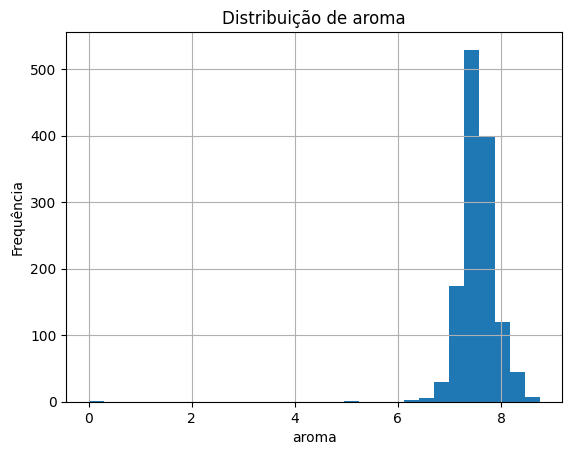

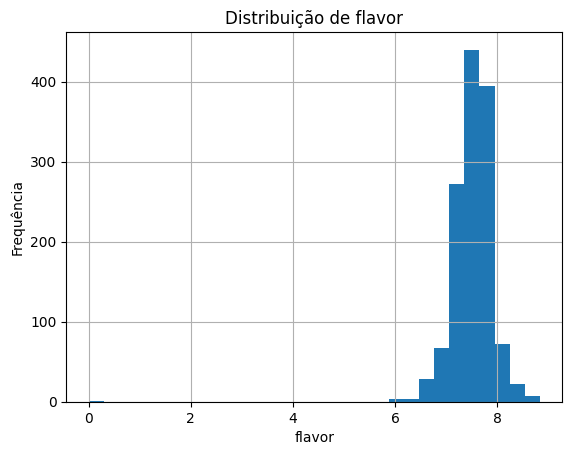

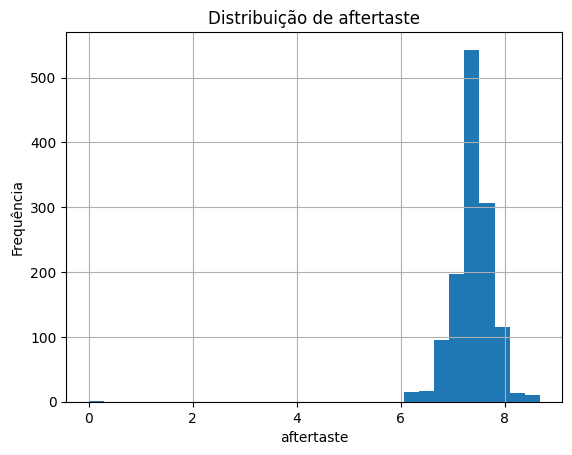

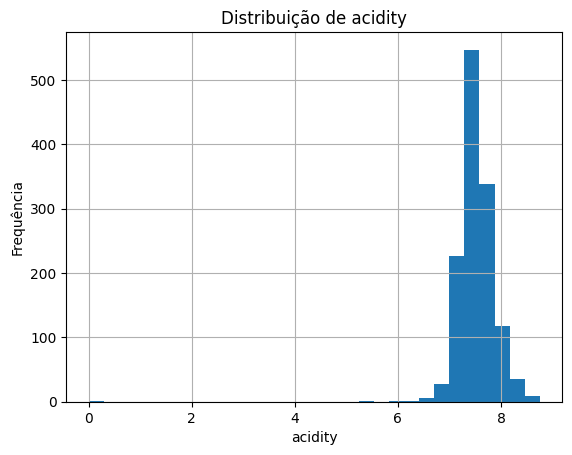

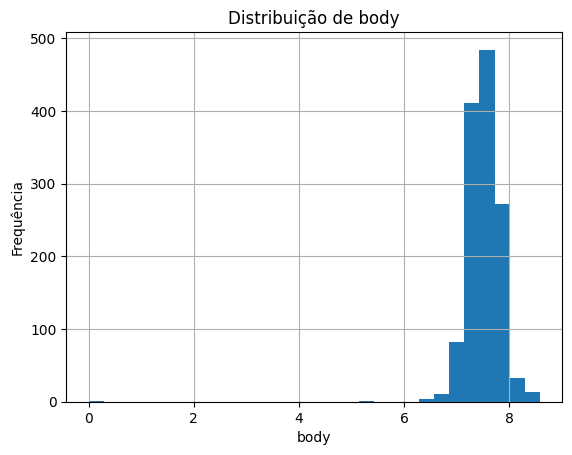

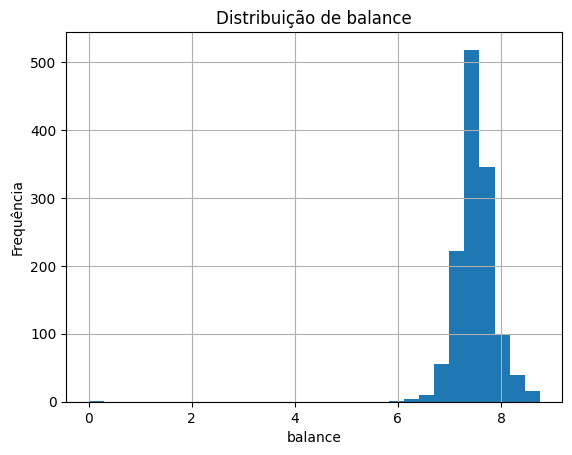

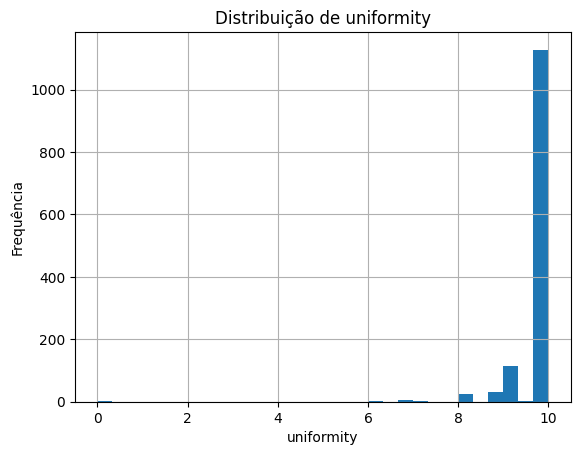

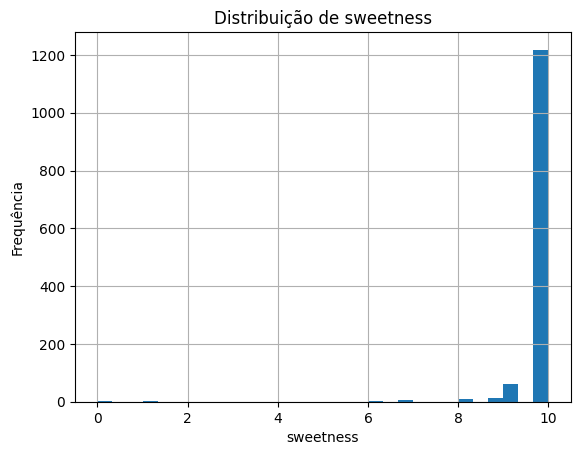

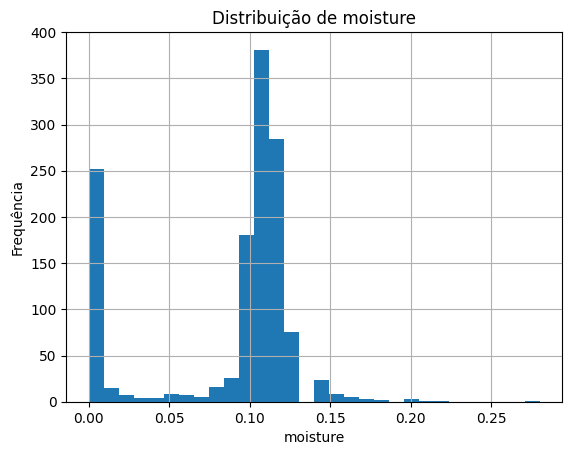

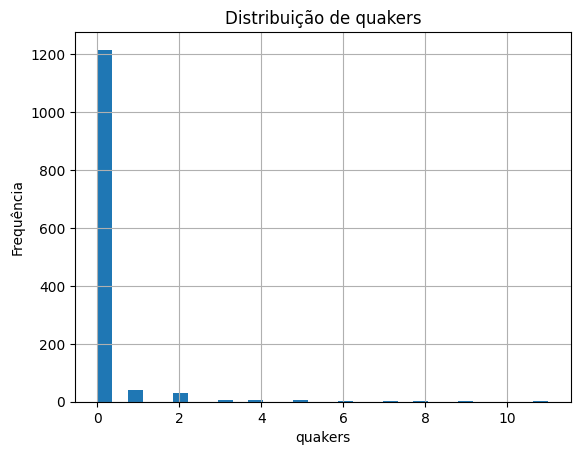

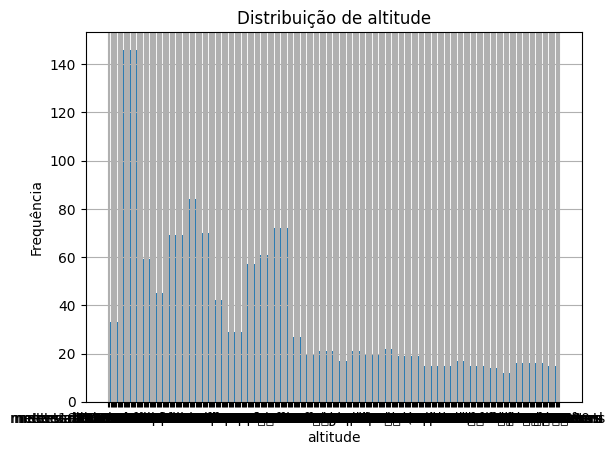

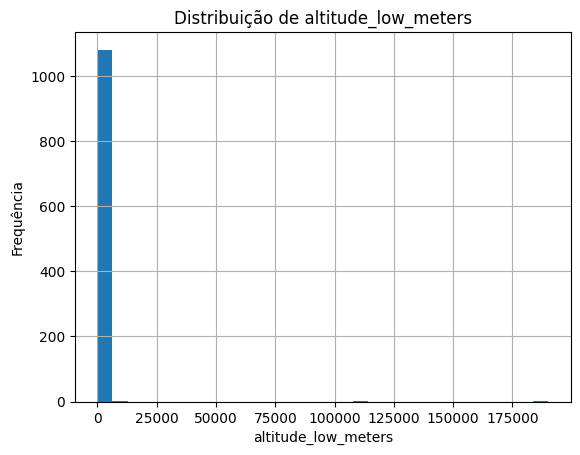

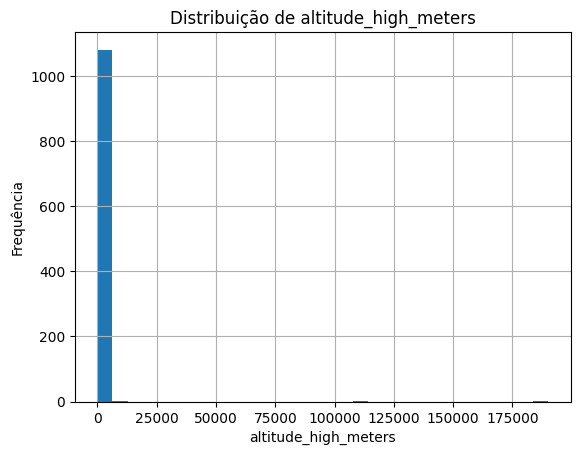

In [4]:

# Distribuições numéricas
for c in num_cols:
    plt.figure()
    df[c].dropna().hist(bins=30)
    plt.title(f"Distribuição de {c}")
    plt.xlabel(c)
    plt.ylabel("Frequência")
    plt.show()


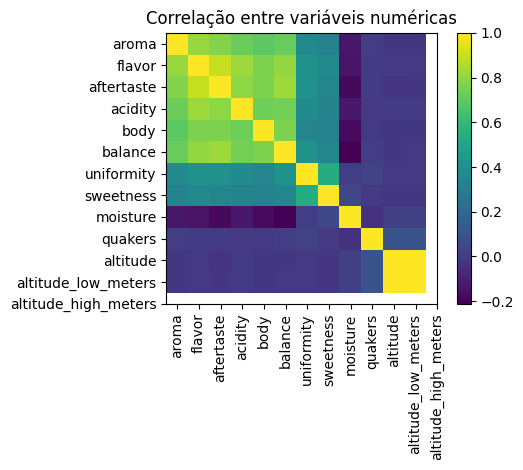

In [5]:

if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure()
    im = plt.imshow(corr, interpolation='nearest')
    plt.title("Correlação entre variáveis numéricas")
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


In [6]:

# Limpeza e engenharia de atributos
before = len(df)
df = df.drop_duplicates()
print("Duplicatas removidas:", before - len(df))

if "altitude_low_meters" in df.columns and "altitude_high_meters" in df.columns:
    df["altitude_mean_meters"] = df[["altitude_low_meters","altitude_high_meters"]].mean(axis=1)


Duplicatas removidas: 0


In [7]:

# Separação de colunas
numeric_features = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
categorical_features = [c for c in df.columns if c not in numeric_features]

if "total_cup_points" in numeric_features:
    numeric_features.remove("total_cup_points")
if "is_specialty" in numeric_features:
    numeric_features.remove("is_specialty")

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [8]:

if "total_cup_points" in df.columns:
    X = df.drop(columns=["total_cup_points","is_specialty"]) if "is_specialty" in df.columns else df.drop(columns=["total_cup_points"])
    y = df["total_cup_points"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    pipe_rf = Pipeline(steps=[("preprocess", preprocess),
                              ("model", RandomForestRegressor(n_estimators=300, random_state=42))])
    pipe_rf.fit(X_train, y_train)
    pred = pipe_rf.predict(X_test)
    print("MAE:", mean_absolute_error(y_test, pred))
    print("R2:", r2_score(y_test, pred))


In [9]:

if "is_specialty" in df.columns:
    Xc = df.drop(columns=["is_specialty","total_cup_points"]) if "total_cup_points" in df.columns else df.drop(columns=["is_specialty"])
    yc = df["is_specialty"]
    Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42, stratify=yc)
    
    pipe_rfc = Pipeline(steps=[("preprocess", preprocess),
                               ("model", RandomForestClassifier(n_estimators=400, random_state=42))])
    pipe_rfc.fit(Xc_train, yc_train)
    pred = pipe_rfc.predict(Xc_test)
    print("Accuracy:", accuracy_score(yc_test, pred))
    print("F1:", f1_score(yc_test, pred))


In [10]:

# ## 8. Exportação de Dados Tratados
df.to_csv("arabica_data_cleaned_prepared.csv", index=False)
print("Arquivo salvo: arabica_data_cleaned_prepared.csv")


Arquivo salvo: arabica_data_cleaned_prepared.csv
